## Image Data Analysis

### Read example image with cv2

In [1]:
from cv2 import imdecode, IMREAD_UNCHANGED
import json
import requests
import numpy as np

all_data = json.load(open('./merged.json'))

def get_image_data(img_url):
    get_image = requests.get(img_url, stream=True)
    raw_image_data = get_image.raw
    image_array = np.asarray(bytearray(raw_image_data.read()), dtype="uint8")
    image_data = imdecode(image_array, IMREAD_UNCHANGED)
    return image_data


In [2]:
height, width, num_channels = get_image_data(all_data['001']['sprites'][0]).shape
(height, width, num_channels)

(120, 120, 4)

In [5]:
from urllib.parse import urlparse
from tqdm import tqdm

bad_eggs = {}

def apply_transformation(data):
    try:
        res = json.load(open('./post_transformation.json'))
    except Exception:
        res = {}
    for ndex in tqdm(list(data.keys())):
        # print(f'running {ndex}')
        if res.get(ndex) is None:
            res[ndex] = data[ndex].copy()
            res[ndex]['sprites'] = {}
        sprites = data[ndex]['sprites']
        for sprite_url in sprites[-100:]:
            # print(sprite_url)
            if sprite_url not in res[ndex]['sprites']:
                # print(f'fetching {sprite_url}')
                try:
                    image_data = get_image_data(sprite_url)
                    ext = sprite_url.split('.')[-1].lower().strip()
                    if ((image_data is None) or (image_data.shape is None)):
                        height = width = num_channels = 'inf'
                    else:
                        height, width, *rest = image_data.shape
                        num_channels = rest[0] if rest else 0
                    res[ndex]['sprites'][sprite_url] = {
                        # 'url': sprite_url,
                        'height': height,
                        'width': width,
                        'num_channels': num_channels,
                        'ext': ext,
                        'domain': urlparse(sprite_url).netloc
                    }
                except Exception as e:
                    bad_eggs[sprite_url] = (ndex, sprite_url, str(e))
            else:
                pass
                # print(f'skipping {sprite_url}')
    return res
    

In [6]:
updated_image_data = apply_transformation(all_data)
json.dump(updated_image_data, open('post_transformation.json', 'w'), indent=4)

100%|█████████████████████████████████████████████████████████████████████████████| 905/905 [11:59:44<00:00, 47.72s/it]


In [9]:
from collections import Counter

import pandas as pd
import numpy as np

domain_counter = Counter()
ext_counter = Counter()
w_h = []
num_channel_counter = Counter()

for ndex in list(updated_image_data.keys()):
    pokemon_data = updated_image_data[ndex]
    for url in pokemon_data['sprites'].keys():
        sprite = pokemon_data['sprites'][url]
        w_h.append([sprite['height'], sprite['width'], sprite['domain']])
        domain_counter[sprite['domain']] += 1
        ext_counter[sprite['ext']] += 1
        num_channel_counter[str(sprite['num_channels'])] += 1

size_df = pd.DataFrame(data=w_h, columns=['height', 'width', 'domain'])
size_df = size_df.replace(to_replace='inf', value=np.nan).dropna()

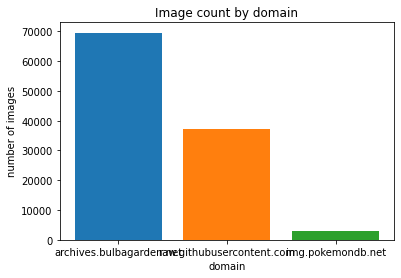

In [10]:
import matplotlib.pyplot as plt

plt.title('Image count by domain')
plt.xlabel('domain')
plt.ylabel('number of images')
for domain, count in domain_counter.items():
    plt.bar(domain, count)


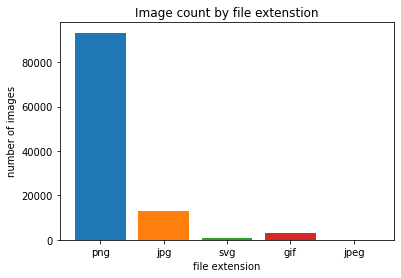

In [11]:
plt.title('Image count by file extenstion')
plt.xlabel('file extension')
plt.ylabel('number of images')
for ext, count in ext_counter.items():
    plt.bar(ext, count)

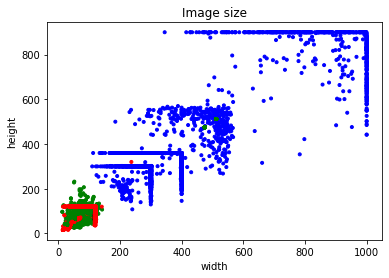

In [12]:
color_map = {'archives.bulbagarden.net': 'red', 'raw.githubusercontent.com': 'green', 'img.pokemondb.net': 'blue'}
color = [color_map[item] for item in size_df['domain']]
plt.title('Image size')
plt.xlabel('width')
plt.ylabel('height')
plt.scatter(size_df['height'], size_df['width'], marker='.', c=color)

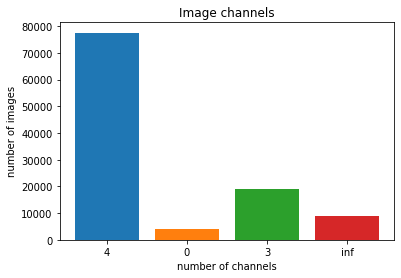

In [13]:
plt.title('Image channels')
plt.xlabel('number of channels')
plt.ylabel('number of images')
for ext, count in num_channel_counter.items():
    plt.bar(ext, count)